In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

def generate_trajectory(n_steps):
    t = np.linspace(0, 10, n_steps)
    x = np.sin(t)
    y = np.cos(t)
    z = t * 0.1  
    return np.array([x, y, z]).T  

def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])  
        y.append(data[i + timesteps])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

class TrajectoryDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X) 
        self.y = torch.tensor(y)  
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)  
        out = self.fc(out[:, -1, :])  
        return out


n_steps = 1000        # Total number of data points
timesteps = 100       # Number of past points to use for prediction
hidden_size = 50     # LSTM hidden units
input_size = 3       # (x, y, z)
output_size = 3      # Predict (x, y, z)

data = generate_trajectory(n_steps)
X, y = create_sequences(data, timesteps)
dataset = TrajectoryDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 130
for epoch in range(epochs):
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.8f}")

# Predict the next position
model.eval()
last_sequence = torch.tensor(data[-timesteps:], dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, timesteps, 3)
with torch.no_grad():
    next_position = model(last_sequence)

# Print results
print("\nLast known position:", data[-1])
print("Predicted next position:", next_position.cpu().numpy()[0])

# Optional: Predict multiple future steps (for trajectory mapping)
def predict_trajectory(model, last_sequence, steps_ahead):
    model.eval()
    trajectory = []
    current_sequence = last_sequence.clone()
    with torch.no_grad():
        for _ in range(steps_ahead):
            pred = model(current_sequence)
            trajectory.append(pred.cpu().numpy()[0])
            current_sequence = torch.cat((current_sequence[:, 1:, :], pred.unsqueeze(1)), dim=1)
    return np.array(trajectory)

# Predict 5 steps ahead
future_trajectory = predict_trajectory(model, last_sequence, 50)
print("\nPredicted trajectory for next 5 steps:")
print(future_trajectory)

Epoch [10/130], Loss: 0.00003808
Epoch [20/130], Loss: 0.00001201
Epoch [30/130], Loss: 0.00001718
Epoch [40/130], Loss: 0.00000396
Epoch [50/130], Loss: 0.00000581
Epoch [60/130], Loss: 0.00000434
Epoch [70/130], Loss: 0.00000106
Epoch [80/130], Loss: 0.00000354
Epoch [90/130], Loss: 0.00000168
Epoch [100/130], Loss: 0.00000194
Epoch [110/130], Loss: 0.00002391
Epoch [120/130], Loss: 0.00000097
Epoch [130/130], Loss: 0.00000149

Last known position: [-0.54402111 -0.83907153  1.        ]
Predicted next position: [-0.5532882  -0.8276427   0.99876344]

Predicted trajectory for next 5 steps:
[[-0.5532882  -0.8276427   0.99876344]
 [-0.56186074 -0.8209326   0.9992181 ]
 [-0.5704024  -0.81405365  0.99963796]
 [-0.57893485 -0.80699193  1.0000054 ]
 [-0.58746547 -0.7997503   1.0003229 ]
 [-0.59599894 -0.7923265   1.0005869 ]
 [-0.6045384  -0.7847155   1.0007926 ]
 [-0.6130868  -0.7769102   1.0009354 ]
 [-0.6216475  -0.76890254  1.0010097 ]
 [-0.63022363 -0.76068354  1.0010098 ]
 [-0.6388188  

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load data from CSV instead of generating synthetic data
df = pd.read_csv('processed_data/processed_data.csv')
position_data = df[['s_x', 's_y', 's_z']].values  # Extract position coordinates

# Create sequences for LSTM training (same as before)
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])  # Sequence of 'timesteps' points
        y.append(data[i + timesteps])    # Next point to predict
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Custom Dataset for PyTorch (same as before)
class TrajectoryDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)  # Shape: (samples, timesteps, features)
        self.y = torch.tensor(y)  # Shape: (samples, features)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the LSTM model (same as before)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)  # out: (batch, timesteps, hidden_size)
        out = self.fc(out[:, -1, :])  # Take the last timestep: (batch, output_size)
        return out

# Parameters - adjusted for orbital data
timesteps = 200       # Number of past points to use for prediction
hidden_size = 64     # LSTM hidden units
input_size = 3       # (s_x, s_y, s_z)
output_size = 3      # Predict (s_x, s_y, s_z)

# Prepare data
X, y = create_sequences(position_data, timesteps)
dataset = TrajectoryDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
for epoch in range(epochs):
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Predict the next position
model.eval()
last_sequence = torch.tensor(position_data[-timesteps:], dtype=torch.float32).unsqueeze(0).to(device)
with torch.no_grad():
    next_position = model(last_sequence)

# Print results
print("\nLast known position:", position_data[-1])
print("Predicted next position:", next_position.cpu().numpy()[0])

Epoch [10/100], Loss: 48210558976.0000
Epoch [20/100], Loss: 43632922624.0000


KeyboardInterrupt: 

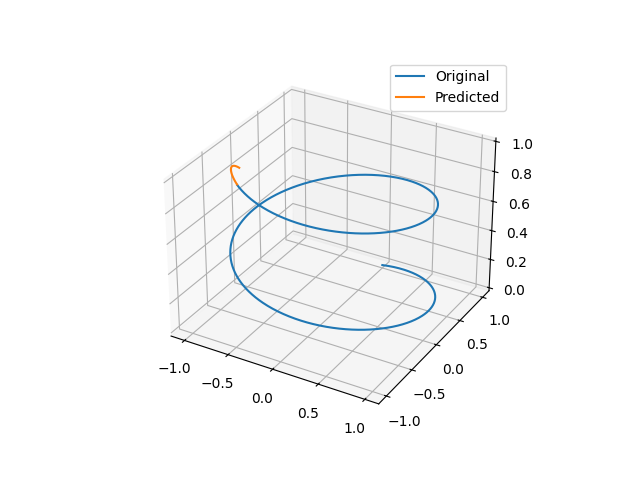

In [10]:
import matplotlib.pyplot as plt
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:, 0], data[:, 1], data[:, 2], label='Original')
ax.plot(future_trajectory[:, 0], future_trajectory[:, 1], future_trajectory[:, 2], label='Predicted')
ax.legend()
plt.show()